In [78]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from skimage.util import view_as_windows

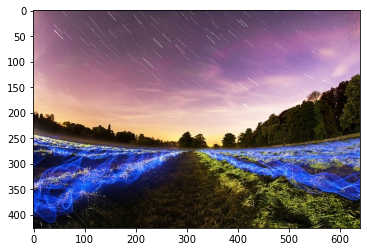

(426, 640, 3)


In [79]:
image = np.array(im.open('sample.bmp'))
plt.imshow(image)
plt.show()
print(image.shape)

In [80]:
# constants for transforming RGB to Y'CbCr
Kr = 0.299  # Kr + Kg + Kb = 1
Kg = 0.587
Kb = 0.114

def rgb2ycbcr(img):
    """
    Transforms image from RGB(A) color space to Y'CbCr color space
    :param img: image in RGB(A), np array (h, w, ch) (ch=3 -> RGB, ch=4 -> RGBA)
    :return: image in Y'CbCr (h, w, 3)
    """
    if img.shape[2] == 4:  # let's ignore the alpha values
        img = img[:, :, 0:3]

    coefficients = np.array([[Kr, Kg, Kb],  # https://en.wikipedia.org/wiki/YCbCr#YCbCr
                             [-0.5 * Kr / (1 - Kb), -0.5 * Kg / (1 - Kb), 0.5],
                             [0.5, -0.5 * Kg / (1 - Kr), -0.5 * Kb / (1 - Kr)]])
    YCbCr = np.dot(img, coefficients.T)
    YCbCr[:, :, 1:] += 128
    return np.uint8(YCbCr)



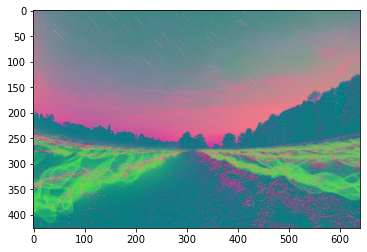

In [83]:
ycbcr = rgb2ycbcr(orig)
plt.imshow(ycbcr)
plt.show()

In [91]:
ycbcr.shape

(426, 640, 3)

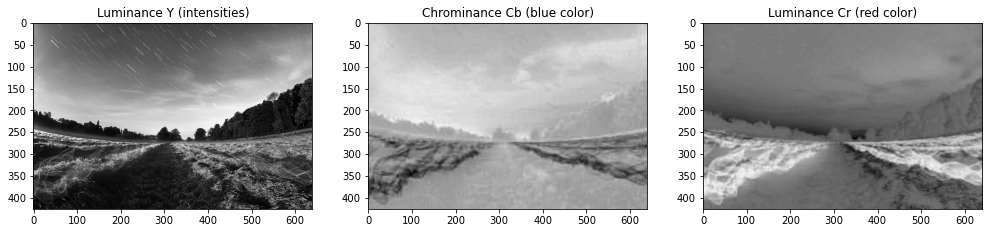

In [96]:
im_ycbcr = im_ycbcr.astype(np.uint8) # Convert 32-bit elements to 8-bit
Y = im.fromarray(im_ycbcr[:,:,0], "L")
Cb = im.fromarray(im_ycbcr[:,:,1], "L")
Cr = im.fromarray(im_ycbcr[:,:,2], "L")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,10))
plt.subplot(1, 3, 1)
plt.title("Luminance Y (intensities)")
plt.imshow(Y,cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Chrominance Cb (blue color)")
plt.imshow(Cr,cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Luminance Cr (red color)")
plt.imshow(Cb,cmap="gray")
plt.show()

In [85]:
def downsample(img, ratio=(2, 2), scikit=False):
    """
    Downsample the chroma channels of given image
    :param img: image in Y'CbCr color space, np array (h, w, ch)
    :param ratio: tuple indicating factor of downsampling in x and y directions
    :param scikit: use scikit library or for loops for downsampling, bool
    :return: list of np channels, where chroma channels are downsampled
    """

    h, w = img.shape[0], img.shape[1]
#     img = np.ones((h+1, w+1, 3))  # try image dimensions that are not divisible by downsmapling ratio
    downsampled = []
    Y = img[:, :, 0]
    Cb = img[:, :, 1]
    Cr = img[:, :, 2]

    shape = (int(h / ratio[0] + h % ratio[0]), int(w / ratio[1] + w % ratio[1]))

    if not scikit:  # my slower version with for loops
        downsampled_Cb = np.zeros(shape)
        downsampled_Cr = np.zeros_like(downsampled_Cb)
        for i in range(0, h, ratio[0]):
            for j in range(0, w, ratio[1]):
                # do the downsampling by averaging the value of the pixels and rounding to the nearest integer
                downsampled_Cb[i // 2, j // 2] = np.round(np.mean(Cb[i: i + ratio[0], j: j + ratio[1]])).astype(int)
                downsampled_Cr[i // 2, j // 2] = np.round(np.mean(Cr[i: i + ratio[0], j: j + ratio[1]])).astype(int)

    else:  # vectorized, hence much faster version of downsampling with skicit-image library
        Cb_windows = view_as_windows(Cb, ratio, ratio)
        Cr_windows = view_as_windows(Cr, ratio, ratio)
        downsampled_Cb = np.round(np.mean(Cb_windows, axis=(2, 3))).astype(int)
        downsampled_Cr = np.round(np.mean(Cr_windows, axis=(2, 3))).astype(int)

    downsampled.extend((Y, downsampled_Cb, downsampled_Cr))

    return downsampled

In [86]:
downsampled = downsample(ycbcr)
print('Dimensions of the channels after downsampling: ', [i.shape for i in downsampled])

Dimensions of the channels after downsampling:  [(426, 640), (213, 320), (213, 320)]


In [87]:
def create_pixel_groups(img):
    """
    Create list of blocks of size block_size x block_size from given image. pAdding is applied if necessary
    :param img: list (3) of channels, due to downsampling not all the channels have the same size
    :return: list (3) of blocks shaped (8, 8)
    """

    block_size = 8  # not as changeable parameter because the quantization tables are 8 x 8
    print([i.shape for i in img])
    for i, channel in enumerate(img):
        h, w = channel.shape
        # padding at the end of image, we copy the values of last row/column in image remainder-times
        if h % block_size != 0:
            remainder = h % block_size
            last_row = channel[-1, :]
            to_add = np.tile(last_row, (remainder, 1))
            channel = np.concatenate((channel, to_add), axis=0)
        if w % block_size != 0:
            remainder = w % block_size
            last_col = channel[:, -1]
            to_add = np.tile(last_col[:, np.newaxis], (1, remainder))
            channel = np.concatenate((channel, to_add), axis=1)
        img[i] = channel
    print([i.shape for i in img])
    pixel_groups = []
    for channel in img:
        h, w = channel.shape
        pixel_block = []
        for i in range(int(h / block_size)):
            for j in range(int(w / block_size)):  # loop over the image and create the groups
                pixel_block.append(channel[i * block_size:(i + 1) * block_size, j * block_size: (j + 1) * block_size])
        pixel_groups.append(pixel_block)

    return pixel_groups

In [88]:
pixel_groups = create_pixel_groups(downsampled)
print([(len(i), i[0].shape) for i in pixel_groups])

[(426, 640), (213, 320), (213, 320)]
[(428, 640), (218, 320), (218, 320)]
[(4240, (8, 8)), (1080, (8, 8)), (1080, (8, 8))]


# Discrete cosine transform
In JPEG coding we use DCT-II version of the discrete cosine transform. The DCT-II is probably the most commonly used form, and is often simply referred to as "the DCT". Its formula looks like this:
<center>$y_k = 2 \sum_{n=0}^{N-1} x_n \cos\left(\frac{\pi k(2n+1)}{2N} \right)$</center>

![Two-dimensional DCT frequencies](dct.png)

In [89]:
def dct_2d(pixel_blocks):
    step1 = np.apply_along_axis(dct_1d, axis=0, arr=pixel_blocks)
    step2 = np.apply_along_axis(dct_1d, axis=1, arr=step1)
    return step2


def dct_1d(pixel_blocks):
    N = pixel_blocks.shape[0]  # 8
    coefficents = np.zeros(N)
    for m in range(N):
        for i in range(N):
            coefficents[m] += pixel_blocks[i] * np.cos((np.pi * m * (2 * i + 1)) / (2 * N))
            # coefficents[m] += pixel_blocks[i] * np.cos((np.pi * m * (2 * i + 1)) / (2 * N))
    return coefficents


def discrete_cosine_transform(pixel_blocks):
    """
    Applies discrete cosine transform to pixel groups (8 x 8) in each channel
    :param pixel_blocks:
    :return: list (3)
    """
    transformed = []
    for channel in pixel_blocks:  # for each channel
        transformed_channel = []
        for block in channel:  # for each pixel block (8 x 8)
            transformed_channel.append(dct_2d(block))  # perform DCT
        transformed.append(transformed_channel)

    return transformed

In [100]:
transformed = discrete_cosine_transform(pixel_groups)

In [105]:
print(transformed[0][].shape)

(8, 8)


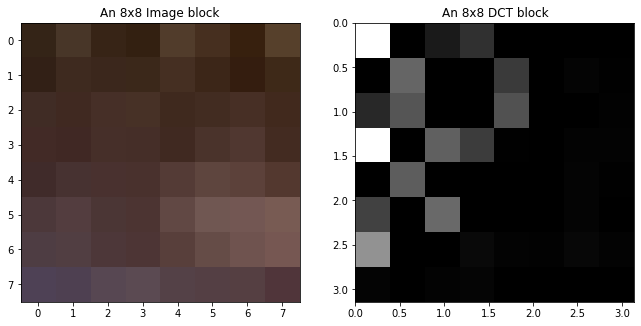

Values of the DCT block:
[[3799.   -200.75   16.15   29.67  -34.65  -67.94    0.2    -0.14]
 [-515.9    60.97  -30.37  -22.42   34.98  -65.13    2.94    1.  ]
 [  25.11   51.29   -1.68  -27.19   48.96  -70.63   -0.35    1.66]
 [ 158.17 -138.54   57.83   36.43    0.79 -105.22    1.92    2.26]
 [ -57.28   56.1   -41.66   -1.38   -4.5    -3.04    2.64    0.72]
 [  39.59  -44.08   63.82   -2.31   -1.23   -0.74    2.5    -0.84]
 [  88.33   -0.     -0.35    5.91    1.91    1.62    4.68    1.87]
 [   2.44   -0.09    2.11    3.43   -1.74   -0.6    -3.84   -2.65]]


In [133]:
# Extract a block from image
pos = 264
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,12))
plt.subplot(1, 3, 1)
plt.imshow(image[pos:pos+8,pos:pos+8],cmap='gray')
plt.title("An 8x8 Image block")

# Display the dct of that block
plt.subplot(1, 3, 2)
h, w, c = image.shape
list_pos = int(((pos/8)*w)/8 + pos/8)
plt.imshow(transformed[0][list_pos],cmap='gray',vmax=np.max(transformed[0])*0.01, vmin = 0, extent=[0,np.pi,np.pi,0])
plt.title( "An 8x8 DCT block")

plt.show()

np.set_printoptions(precision=2, suppress=True)
print('Values of the DCT block:')
print(transformed[0][list_pos])